In [19]:
import csv
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import tempfile

import preprocessor as p


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import RSLPStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools


%matplotlib inline

# Métodos de Pré Processamento 

In [20]:
def remove_stopwords(text):
     # remove punctuation
    chars = ['…','.', '/', ''', ''', '?', '!', '$', '%', '^', '&',
             '*', '(', ')', ' - ', '_', '+', '=', '@', ':',
             '\\', ',',
             ';', '~', '`', '<', '>', '|', '[', ']', '{', '}',
             '–', '“',
             '»', '«', '°', '’', '1', '2',
             '3', '4', '5', '6', '7', '8', '9', '0', 'https', 'http']
    for c in chars:
        text= text.replace(c,' ').lower()
    text = text.split()
    import nltk
    # Caso seja preciso mudar o idioma, basta inserir o idioma desejado no parâmetro.
    stopwords = nltk.corpus.stopwords.words('portuguese')
    content = [w for w in text if w.lower().strip() not in stopwords]

    return content

In [22]:
def tokenize(text):
    tokens = word_tokenize(text)
    porter = RSLPStemmer()
    tokens = [porter.stem(t) for t in tokens]
    tokens = [
                t for t in tokens
                    if len(t)> 2 and not t.isdigit()
    ]
    return tokens

In [23]:
def remove_emoji(text):
#    print(text)
   d=[]
   d = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
   d = d.sub(r'', text)
   return d

In [24]:
def remove_url(text):
   b=[]
   b = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
   return b

In [25]:
def remove_mentions(text):
   c=[]
   c = re.sub(r"(?:\@|https?\://)\S+", "", text)
   c = re.sub('[rt]', "", c)
   return c

In [26]:
def remove_hashtag(text):
    words = text.split()
    for i in words:
        if i.startswith('#'):
            words.remove(i)
    text = ''.join(text)
    return text

In [27]:
def aplica_steaming(text):
    stemmer = nltk.steam.RLSPStemmer()
    tweetsStemming = []
    for doc in text:
        comStemming = [srt(stemmer.steam(d)) for d in text.splip()]
        tweetsStemming.append(comStemming)

In [28]:
dataset = csv.reader(open('data/desbalanciada-imdb-pt-br.csv', 'r', encoding='utf-8'))
list_docs = []
list_labels = []

for row in dataset:
    list_docs.append(row[1])
    list_labels.append(row[2])

In [12]:
print(list_docs[0], list_labels[0])

Quando eu assisti pela primeira vez Flatliners, fiquei espantado. Tinha todas as características necessárias de um bom filme: o elenco era soberbo, o enredo era soberbo e, no caso dos thrillers, havia genuínos "arrepios" em todo o lado.Keifer Sutherland ofereceu uma performance maravilhosa como o protagonista masculino da peça, retratando um cientista que acredita poder encontrar as respostas para a vida e a morte matando-se e voltando à vida, essencialmente "roubando" os segredos das mortes. Kevin Bacon oferece um excelente desempenho como a contraparte mais moralmente decente de Keifer, enquanto Julia Roberts oferece seu papel mais convincente. William Baldwin retrata um aluno que se destaca na aula e, aparentemente, na relação sexual. E Oliver Platt, em outro excelente desempenho, retrata a voz da razão para o grupo e os mais inocentes. A história é relativamente simples, mas original, e a atuação é refrescante - definitivamente um filme de destaque para o gênero, e um que definiu o

In [29]:
count_neg=0
count_pos=0

list_neg=[]
list_pos=[]

documents = []
labels    = []

doc = []
with open('data/desbalanciada-imdb-pt-br.csv','r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter =',')
    for row in reader:
        if row[2]=='neg':
            count_neg+=1
            list_neg.append(row[2])
        else:
            count_pos+=1
            list_pos.append(row[2])
            
        documents.append(row[1])
        labels.append(row[2])

In [30]:
clean_documents = []
for doc in documents:
    #usando as funcões da tweetpreprocess
    tweetsLimpos = p.clean(doc)
    tweetsPreProcessados = remove_stopwords(tweetsLimpos)
    #tokenizado = tokenize(tweetsPreProcessados)
    document = ' '.join(tweetsPreProcessados)
    clean_documents.append(document)

    
tokenizado_documents = []
for doc in clean_documents:
    tokenizado = tokenize(doc)
    document = ' '.join(tokenizado)
    tokenizado_documents.append(document)

In [15]:
print(tokenizado_documents[0])

assist prim vez flatlin fiq espant tod caracterís necessár bom film elenc soberb enred soberb cas thrill hav genuín arrepi tod lad keif sutherland oferec performanc maravilh protagon masculin peç retrat cient acredit pod encontr respost vid mort matando-s volt vid essenc roub segred mort kevin bacon oferec excel desempenh contrapart moral decent keif enquant jul robert oferec papel convinc will baldwin retrat alun destac aul aparent relaç sex oliv platt outr excel desempenh retrat voz grup inoc histór relativ simpl orig atu refresc definitiv film destaqu gêner defin padr med outr thrill mim


# Matrix de Confusão

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')

# DESCRIÇÃO DA BASE DE DADOS

2999
1001


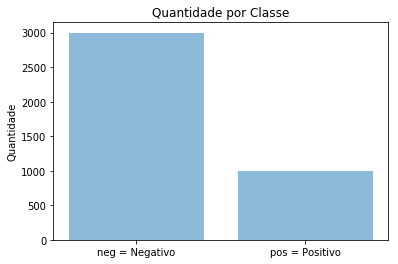

In [36]:
objects = ('neg = Negativo', 'pos = Positivo')
y_pos = np.arange(len(objects))
performance = [count_neg, count_pos]

plt.bar(y_pos, performance, align='center',alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Quantidade')
plt.title('Quantidade por Classe')

print(count_neg)
print(count_pos)

plt.show()

# TF-IDF

In [37]:
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(tokenizado_documents)
y = labels

# MÉTRICAS: ACURÁCIA, F1, RECALL, PRECISION

In [34]:
def train(classifier, X, y, class_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=81)
    
    ##TREINANDO MEU ALGORITMO
    classifier.fit(X_train, y_train)
    
    ##Predicoes para medição da Acurácia
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    print("Acurracia: %s" % classifier.score(X_test,y_test))
    print("F1: %s" % str(f1_score(y_test, y_pred, average=None )))
    print("Recall: %s"% str(recall_score(y_test, y_pred, average=None)))
    print("Precision: %s" % str(precision_score(y_test, y_pred, average=None)))
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de Confusao')
    
    plt.show()
    
    return classifier

# MultinomialNB

Acurracia: 0.93
F1: [0.95 0.85]
Recall: [0.99 0.76]
Precision: [0.92 0.96]
Confusion matrix, without normalization
[[292   3]
 [ 25  80]]


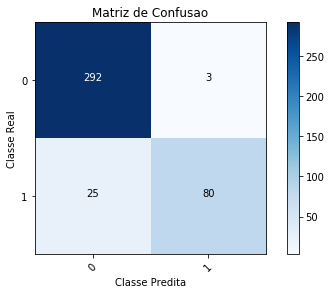

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

In [47]:
train(MultinomialNB(alpha=0.05), X, y, ['0','1'])

# Suport Vector Machine 

Acurracia: 0.945
F1: [0.96 0.88]
Recall: [1.  0.8]
Precision: [0.93 0.99]
Confusion matrix, without normalization
[[294   1]
 [ 21  84]]


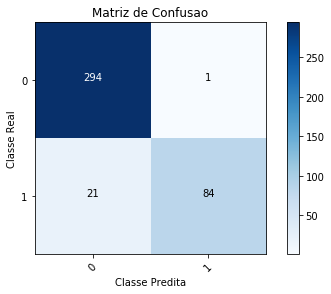

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [48]:
train(svm.SVC(kernel='linear', C=1.0), X,y, ['0','1'])

# SGDClassifier

c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Acurracia: 0.945
F1: [0.96 0.89]
Recall: [0.99 0.83]
Precision: [0.94 0.96]
Confusion matrix, without normalization
[[291   4]
 [ 18  87]]


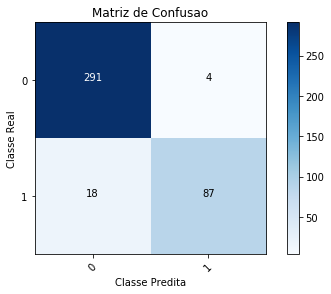

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [49]:
train(SGDClassifier(alpha=0.0001), X,y, ['0','1'])

In [51]:
from multiscorer import MultiScorer
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


models = [MultinomialNB(alpha=0.05), svm.SVC(kernel='linear', C=1.0), SGDClassifier(alpha=0.0001)]
names = ['MultinomialNB', 'SVM', 'SGDC']

scorer = MultiScorer({
    'Accuracy' : (accuracy_score, {}),
    'Precision' : (precision_score, {'pos_label': 3, 'average':'macro'}),
    'Recall' : (recall_score, {'pos_label': 3, 'average':'macro'})
})

for model, name in zip(models, names):
    print (name)
    start = time.time()

    cross_val_score(model, X, y,scoring=scorer, cv=5)
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %f' % (metric_name, average_score))

    print ('time :', time.time() - start, '\n\n')
    
#    for metric_name in results.keys():
#        average_score = np.average(results[metric_name])
#        print('%s : %f' % (metric_name, average_score))
#    
#    print ('time :', time.time() - start, '\n\n')

#scores_MultinomialNB_classifier = cross_validate(MultinomialNB_classifier, X, y, cv=cv, scoring=scoring)
#print (scores.keys(), 
#       scores_MultinomialNB_classifier)

#scores_SVM_classifier = cross_validate(SVM_classifier, X, y, cv=cv, scoring=scoring)
#print (scores.keys(),
#       scores_SVM_classifier)

#scores_SGDC_Classifier = cross_val_score(SGDC_Classifier, X, y, cv=cv, score=scoring)
#print (scores_SGDC_Classifier)

MultinomialNB


c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
c:\users\jarde\appdata\local\programs\python\python3

Accuracy : 0.786992
Precision : 0.755281
Recall : 0.605699
time : 3.866770029067993 


SVM


c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Accuracy : 0.806246
Precision : 0.802755
Recall : 0.636523
time : 57.11183738708496 


SGDC


c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Accuracy : 0.812832
Precision : 0.810105
Recall : 0.651012
time : 0.25332188606262207 


